In [39]:
import cv2
import os
import numpy as np

def empty_folder(folder):
    if not os.path.exists(folder):
        return
    files = os.listdir(folder)
    for file in files:
        file_path = os.path.join(folder, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

def extract_frames(mp4_path, start_frame, end_frame, stride, save_dir='data/mario', 
                   test_split=0.2, size = (64,64)):
    video = cv2.VideoCapture(mp4_path)
    empty_folder(save_dir)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames in video:", total_frames)
    if start_frame < 0 or start_frame >= total_frames:
        raise ValueError("Invalid start frame number")
    if end_frame < 0 or end_frame >= total_frames:
        raise ValueError("Invalid end frame number")
    if start_frame > end_frame:
        raise ValueError("Start frame number cannot be greater than end frame number")
    current_frame = start_frame
    frames = []
    while current_frame <= end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        ret, frame = video.read()
        if not ret:
            raise ValueError("Error reading frame")
        frame = cv2.resize(frame, size)
        if np.random.rand() > test_split:
            cv2.imwrite(os.path.join(save_dir, "train", f"frame_{current_frame}.jpg"), frame)
        else:
            cv2.imwrite(os.path.join(save_dir, "test", f"frame_{current_frame}.jpg"), frame)
        cv2.imwrite(os.path.join(save_dir, f"frame_{current_frame}.jpg"), frame)
        frames.append(frame)
        current_frame += stride
    video.release()
    return frames

In [45]:
start = 400
end = 1500
stride = 2
frames = extract_frames("data/videos/mario_gameplay.mp4", start, end, stride, size=(64,64))
path_dir = 'data/mario/train'
image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]
len(image_files)

Total frames in video: 69878


448

Frame number: 1498


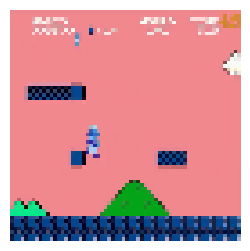

In [46]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

i = 33
for i in range(0, len(frames), 3):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(frames[i])
    print("Frame number:", start + stride * i)
    plt.show()
    time.sleep(0.05)  # Add a 1-second wait time

In [81]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
class marioDataset(Dataset):
    def __init__(self, path_dir, num_frames=4, train=True, transform=None):
        self.dir = os.path.join(path_dir, "train" if train else "test")
        self.num_frames = num_frames
        self.transform = transform
        self.image_files = [f for f in os.listdir(self.dir) if os.path.isfile(os.path.join(path_dir, f))]

    def __len__(self):
        return len(self.image_files)//self.num_frames 
    
    def __getitem__(self, idx):
        # Load the image from the file
        images = []
        for i in range(self.num_frames):
            img_path = os.path.join(self.dir, self.image_files[idx + i])
            with Image.open(img_path).convert("RGB") as image:
                image = self.transform(image)
                images.append(image)
        images = torch.stack(images)
        return images
    
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the DataLoader
for batch in data_loader:
    print(batch.shape)
    break 

torch.Size([4, 1, 3, 64, 64])


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

from torch import nn 
import numpy as np
class residualBlock(nn.Module):
    def __init__(self, ni, nf, use_batchnorm=True): 
        super().__init__()
        self.ni = ni
        self.nf = nf
        self.activation = nn.GELU()
        self.conv1 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        if ni == nf:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(ni, nf, kernel_size=1, stride=1)
    def forward(self, x):
        residue = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + self.skip(residue)
        x = self.activation(x)
        return x

class downSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        self.activation = nn.GELU()
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x
    
class upSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.activation = nn.GELU()
        self.upSample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        x = self.upSample(x)
        x = self.conv(x)
        x = self.activation(x)
        return x

class patchify(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    def forward(x, patch_size):
        batch_size, n_channels, width, height = x.size()
        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(batch_size, n_channels, -1, patch_size, patch_size).permute(0, 2, 1, 3, 4)
        #patches = patches.contiguous().view(batch_size, -1, n_channels * patch_size * patch_size)
        return patches
    
class attentionBlock(nn.Module):
    def __init__(self, n_input, n_emb, n_heads=4):
        super().__init__()
        self.flatten = nn.Flatten()
        self.n_input = n_input
        self.n_emb = n_emb
        self.fc1 = nn.Linear(n_input, n_emb)
        self.attention = nn.MultiheadAttention(n_emb, n_heads, bias=True,  batch_first=True)
        self.fc2 = nn.Linear(n_emb, n_input)

    def forward(self, x):
        batch_size, n_channels, h, w = x.size()
        x = x.view(batch_size, n_channels, -1)
        x = self.linear(x)
        x, _ = self.attention(x, x, x)
        x = self.fc2(x)
        x = x.view(batch_size, n_channels, h, w)
        return x
        
class vae(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            downSample(3, 8),
            residualBlock(8, 8),
            residualBlock(8, 16),
            downSample(16, 16),
            residualBlock(16, 16),
            residualBlock(16, 32),
            downSample(32, 32),
            residualBlock(32, 32),
            downSample(32, 32),
            residualBlock(32, 32)
            #nn.Linear(8 * 8 * 64, latent_dim)
        )
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 8 * 8 * 64),
            residualBlock(32, 32),
            upSample(32, 32),
            residualBlock(32, 32),
            upSample(32, 32),
            residualBlock(32, 32),
            residualBlock(32, 16),
            residualBlock(16, 16),
            upSample(16, 16),
            residualBlock(16, 8),
            residualBlock(8, 8),
            upSample(8, 3)
        )
        self.loss_func = nn.MSELoss()
        self.bn1 = nn.BatchNorm1d(latent_dim)
        self.drop = nn.Dropout(0.2)

    def encode(self, x):
        return self.drop(self.encoder(x))
    def decode(self, x):
        return self.decoder(x)
    def forward(self, x):
        latent = self.encoder(x)
        #latent = self.bn1(latent)
        latent = self.drop(latent)
        out = self.decoder(latent)
        with torch.no_grad():
            pass
            #reconstructed_features = self.encoder(out)
        loss = self.loss_func(out, x) #+ perceptual_loss(latent, reconstructed_features, beta=1)
        return loss, out, latent
    
def perceptual_loss(x_features, y_features, beta=1.0, criterion=nn.MSELoss()):
    x_features.view(x_features.size(0), -1)
    y_features.view(y_features.size(0), -1)
    loss = criterion(x_features, y_features)
    return loss * beta
    
def sample_image(model, dataset, generator=None):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(generator) if generator else None
        
        random_idx = np.random.randint(0, len(dataset))
        random_idx = torch.randint(0, len(dataset), (1,)).item()
        random_image = dataset[random_idx].view(-1, 3, 64, 64).to(device)
        loss, reconstructed_image, latent_space = model(random_image)
        
        # Clip the data to the valid range [0, 1]
        random_image = torch.clamp(random_image, 0, 1)
        reconstructed_image = torch.clamp(reconstructed_image, 0, 1)

        fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
        
        # Original image
        axes[0].imshow(random_image.squeeze(0).transpose(2, 0).transpose(0, 1).cpu())
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Reconstructed image
        axes[1].imshow(reconstructed_image.squeeze(0).transpose(2, 0).transpose(0, 1).cpu())
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')
        
        plt.show()


In [55]:
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
our_vae = vae().to(device)
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

def update_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

num_epochs = 50
learning_rate = 0.003

optimizer = torch.optim.Adam(our_vae.parameters(), lr=learning_rate)

In [84]:
model1 = our_vae
data1 = dataset

In [382]:
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)

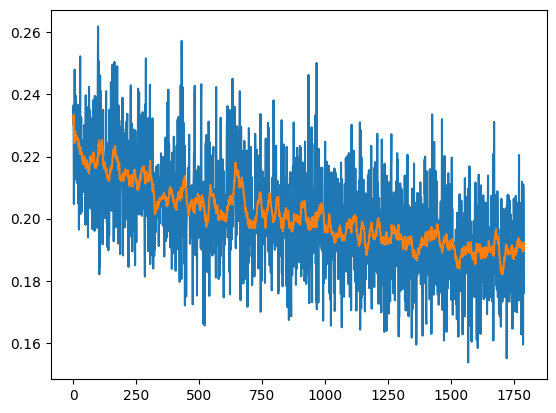

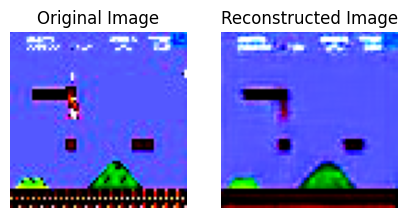

loss: 0.1896, epoch: 16, batch: 0
loss: 0.1913, epoch: 17, batch: 0
loss: 0.1869, epoch: 18, batch: 0
loss: 0.1916, epoch: 19, batch: 0


In [86]:
losses = []
losses_mean = []
for epoch in range(20):
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()
        input = batch.view(-1, 3, 64, 64).to(device)
        loss, _, _ = our_vae(input)
        loss.backward()
        losses.append(loss.item())
        loss_mean = torch.tensor(losses[-20:-1]).mean()
        losses_mean.append(loss_mean)
        #print(f'loss: {loss.item():.4f}, epoch: {epoch}, batch: {i}')
        optimizer.step()
        if i % 1000 == 0:
            pass
            #clear_output()
            #plt.plot(losses)
            #sample_image(our_vae, dataset)
            #plt.show()
            #loss_mean = torch.tensor(losses).mean()
            #losses_mean.append(loss_mean)
            print(f'loss: {loss_mean:.4f}, epoch: {epoch}, batch: {i}')
            pass
    if epoch % 5 == 0:
        clear_output()
        plt.plot(losses)
        plt.plot(losses_mean)
        sample_image(our_vae, dataset)
        plt.show()

    #learning_rate = 0.0001# * (0.1 ** (epoch / 10))
    if epoch % 10 == 0 and epoch != 0:
        learning_rate /= 1
    #print(f'New learning rate: {learning_rate}')
    #update_learning_rate(optimizer, learning_rate)


epoch: 40, lr= 0.001, loss = 1.243


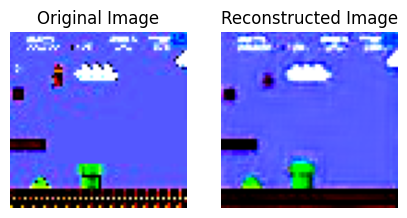

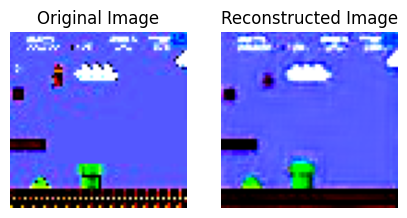

(None, None)

In [90]:
p = np.random.randint(100)
sample_image(our_vae, dataset, generator=p), sample_image(model1, dataset, generator=p)


In [282]:
torch.save(our_vae.state_dict(), 'weights/vae.pth')
torch.save(dataset, 'weights/dataset.pth') 